In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import cv2
import os

In [16]:
train_path = ('/kaggle/input/brain-tumor-classification-mri/Training/')
test_path = ('/kaggle/input/brain-tumor-classification-mri/Testing/')

In [17]:
def read_data(path,image_size = 224):
    X = []
    y = []
    labels = os.listdir(path)
    for label in labels:
        for image in tqdm(os.listdir(path + label)):
            img = cv2.imread(os.path.join(path + label,image))
            img = cv2.resize(img,(image_size, image_size))
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

In [18]:
X_train, y_train = read_data(train_path, image_size=224)
X_test, y_test = read_data(test_path, image_size=224)

100%|██████████| 100/100 [00:01<00:00, 80.60it/s]


## Let's now explore our training data

#### Take a look at some randomly selected images along with their labels

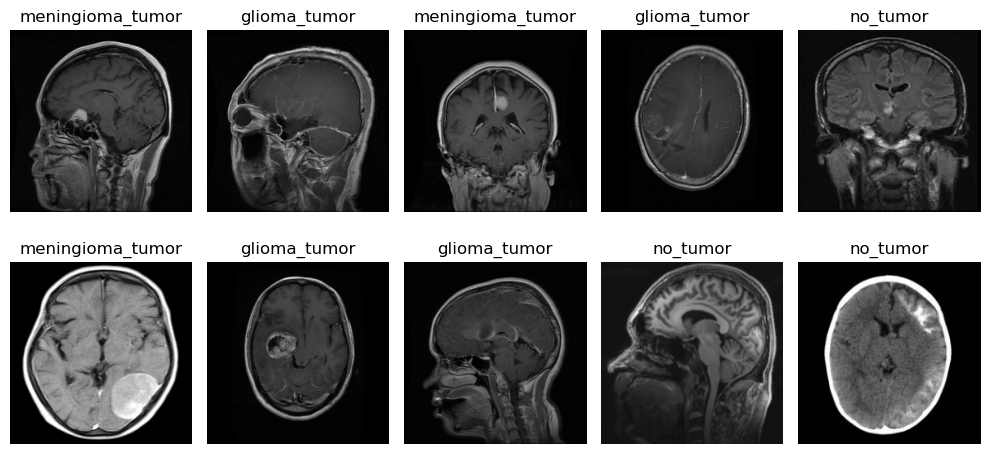

In [20]:
# Select 10 random indices
indices = np.random.choice(len(X_train), size=10, replace=False)

# Plot the 10 random images
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.ravel()

for i, idx in enumerate(indices):
    axs[i].imshow(X_train[idx])
    axs[i].set_title(y_train[idx])
    axs[i].axis('off')

plt.tight_layout()
plt.show()

#### Now let's see the dimensions of our images and check for number of channels. This is important to ensure that it can work with pre-trained models such as ResNet.

In [8]:
# Select an image
image_idx = 30  # Change this to select a different image
image = X_train[image_idx]

# Check if the image is grayscale or RGB
channels = image.shape[2]
if channels == 1:
    print("The image is grayscale")
elif channels == 3:
    print("The image is RGB")
else:
    print("The image has an unexpected number of channels:", channels)

The image is RGB


#### We can see our images are the perfect dimension for ResNet! Therefore, we do not have to make changes to the input layer and only have to worry about fine-tuning the output layer.

In [9]:
image.shape

(224, 224, 3)

#### We can see that our y_train is an array of strings denoting the tumor type. We must one-hot encode this array so that we can use it for our ResNet model.

In [22]:
y_train[:10]

array(['no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor',
       'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor', 'no_tumor'],
      dtype='<U16')

In [25]:
from keras.utils import to_categorical

# Assuming that `y_train` is an array of strings
labels = list(set(y_train))
num_classes = len(labels)

# Convert labels to integers
label_to_int = dict(zip(labels, range(num_classes)))
y_train_int = [label_to_int[label] for label in y_train]

# One-hot encode the labels
y_train_encoded = to_categorical(y_train_int, num_classes=num_classes)

#### Make sure the dimensions of X_train and y_train are compatible and are what we expect.

In [24]:
print('The shape of X_train is', X_train.shape)
print('The shape of y_train is', y_train_encoded.shape)

The shape of X_train is (2870, 224, 224, 3)
The shape of y_train is (2870, 4)


## Let's now create and train a ResNet50 model for our brain tumor classification problem.

#### We will create a model without Dropout or Early Stopping. Later, we will implement a model incorporating these regularization techniques and compare overall performance. We will also implement an adaptive learning rate.

In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50

# load pretrained model with weights corresponding to parameters learned on dataset
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# freeze layers preceding output layer so that trained parameters are not updated
for layer in base_model.layers:
    layer.trainable = False
    
    
# --- Output Layer ---
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
#  softmax final prediction
predictions = tf.keras.layers.Dense(units=4, activation='softmax')(x)
# -- End of Output Layer ---

# Now create new model using our new output layer
final_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

final_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = final_model.fit(X_train, y_train_encoded,validation_split=0.1, epochs=10)

Epoch 1/10
81/81 [==============================] - 16s 147ms/step - loss: 0.6245 - accuracy: 0.7569 - val_loss: 0.3852 - val_accuracy: 0.8118
Epoch 2/10
81/81 [==============================] - 9s 111ms/step - loss: 0.3223 - accuracy: 0.8757 - val_loss: 0.2768 - val_accuracy: 0.8606
Epoch 3/10
81/81 [==============================] - 9s 113ms/step - loss: 0.2388 - accuracy: 0.9144 - val_loss: 0.2890 - val_accuracy: 0.8746
Epoch 4/10
81/81 [==============================] - 9s 114ms/step - loss: 0.1902 - accuracy: 0.9299 - val_loss: 0.4459 - val_accuracy: 0.8084
Epoch 5/10
81/81 [==============================] - 9s 112ms/step - loss: 0.1736 - accuracy: 0.9353 - val_loss: 0.3243 - val_accuracy: 0.8571
Epoch 6/10
81/81 [==============================] - 9s 113ms/step - loss: 0.1327 - accuracy: 0.9551 - val_loss: 0.2383 - val_accuracy: 0.8780
Epoch 7/10
81/81 [==============================] - 9s 111ms/step - loss: 0.1082 - accuracy: 0.9628 - val_loss: 0.0862 - val_accuracy: 0.9617
Epoch

#### We can see that there is some overfitting occurring. Though our minimum validation loss occurs at 6 epochs, we continue training beyond this point, resulting in overfitting. Therefore, an adaptive learning rate and/or Early Stopping may help prevent this.

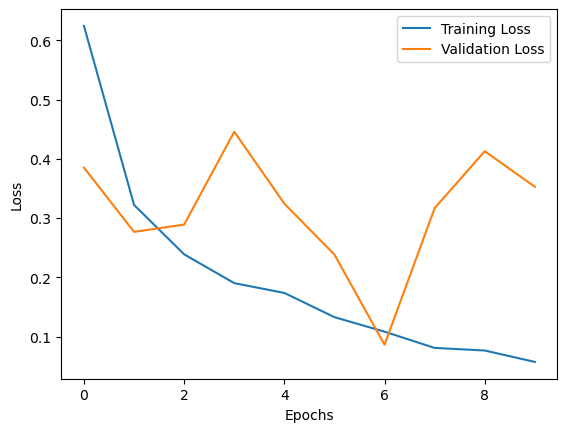

In [41]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Sanity check: make sure our output layer aligns with what we expect. Additionally, the model summary gives us a general sense of the ResNet50 architecture.

In [46]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Let's now prepare our test data and evaluate our model's performance on it.

In [28]:
# Assuming that `y_test` is an array of strings
labels = list(set(y_test))
num_classes = len(labels)

# Convert labels to integers
label_to_int = dict(zip(labels, range(num_classes)))
y_test_int = [label_to_int[label] for label in y_test]

# One-hot encode the labels
y_test_encoded = to_categorical(y_test_int, num_classes=num_classes)

#### Our model is now trained. Let's see how it does on the testing set. Note that since we did not include dropout or early stopping in the training process, there is a possibility of overfitting.

In [29]:
# Get predictions and one-hot encode so that y_test_encoded and y_pred_encoded can be compared

y_pred = final_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_encoded = to_categorical(y_pred_labels)

13/13 [==============================] - 3s 134ms/step


In [30]:
# Check to see that our matrixes are the same size
print('The shape of y_pred_encoded is', y_pred.shape)
print('The shape of y_test_encoded is', y_test_encoded.shape)

The shape of y_pred_encoded is (394, 4)
The shape of y_test_encoded is (394, 4)


In [31]:
y_pred_encoded

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [32]:
y_test_encoded

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

#### We will now assess model performance based on various metrics, including precision and f1-score

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted')
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')

# Print the metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.7639593908629442
Precision: 0.8375696811814148
Recall: 0.7639593908629442
F1 score: 0.7293597036894145


#### According to our confusion matrix, it seems our model is having the most difficulty differentiating between 'meningioma tumors' and 'glioma tumors'

<AxesSubplot:>

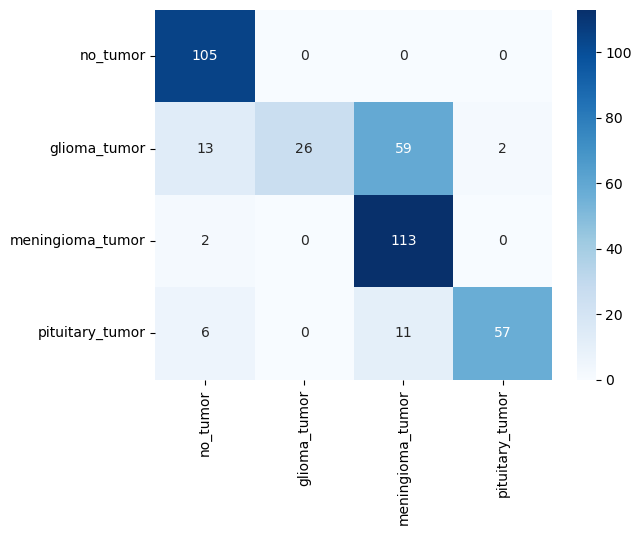

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# convert one-hot labels back to class labels
y_true_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_encoded, axis=1)

cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_encoded, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=list(set(y_test)), yticklabels=list(set(y_test)))

#### Let's now implement some regularization techniques to see if this improves model performance. Though Dropout can be an effective form of regularization, we will avoid this altogether since our training set is small, and Dropout might prevent our model from learning valuable information in the model. We will implement Early Stopping and an adaptive learning rate.

In [50]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# load pretrained model with weights corresponding to parameters learned on dataset
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# freeze layers preceding output layer so that trained parameters are not updated
for layer in base_model.layers:
    layer.trainable = False
    
# --- Output Layer ---
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
#  softmax final prediction
predictions = tf.keras.layers.Dense(units=4, activation='softmax')(x)
# -- End of Output Layer ---
 
# Early Stopping regularization
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# adpative learning rate regularization
adaptive_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,
                              mode='val_loss',verbose=1)

final_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
final_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = final_model.fit(X_train, y_train_encoded, epochs=10, validation_split=0.1, 
                          callbacks=[early_stop, adaptive_lr])

Epoch 1/10
81/81 [==============================] - 14s 128ms/step - loss: 0.6324 - accuracy: 0.7542 - val_loss: 0.5142 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 2/10
81/81 [==============================] - 9s 107ms/step - loss: 0.3360 - accuracy: 0.8738 - val_loss: 0.8172 - val_accuracy: 0.7003 - lr: 0.0010
Epoch 3/10
81/81 [==============================] - 9s 112ms/step - loss: 0.2356 - accuracy: 0.9133 - val_loss: 0.1342 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 4/10
81/81 [==============================] - 9s 116ms/step - loss: 0.2241 - accuracy: 0.9191 - val_loss: 0.4990 - val_accuracy: 0.7875 - lr: 0.0010
Epoch 5/10
81/81 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9462
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
81/81 [==============================] - 10s 118ms/step - loss: 0.1588 - accuracy: 0.9462 - val_loss: 0.2452 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 6/10
81/81 [==============================] - 9s 111ms/st

#### Let's now assess the performance of our regularized model.

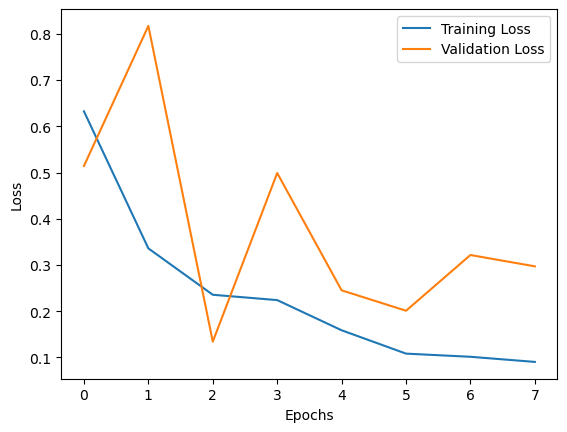

In [51]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

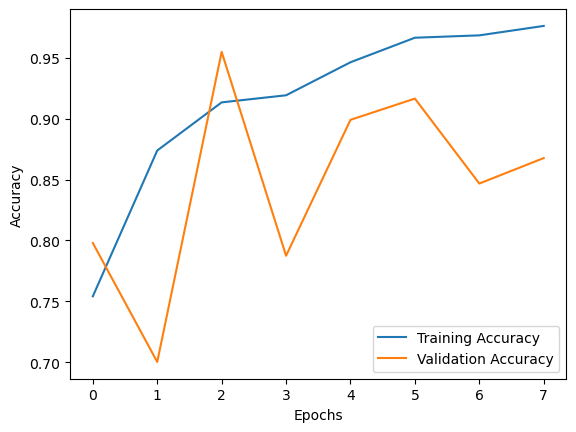

In [52]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
y_pred = final_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_encoded = to_categorical(y_pred_labels)

13/13 [==============================] - 2s 93ms/step


In [54]:
# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_encoded, y_pred_encoded, average='weighted')
recall = recall_score(y_test_encoded, y_pred_encoded, average='weighted')
f1 = f1_score(y_test_encoded, y_pred_encoded, average='weighted')

# Print the metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Accuracy: 0.6218274111675127
Precision: 0.7181065118095336
Recall: 0.6218274111675127
F1 score: 0.6038489999826823


<AxesSubplot:>

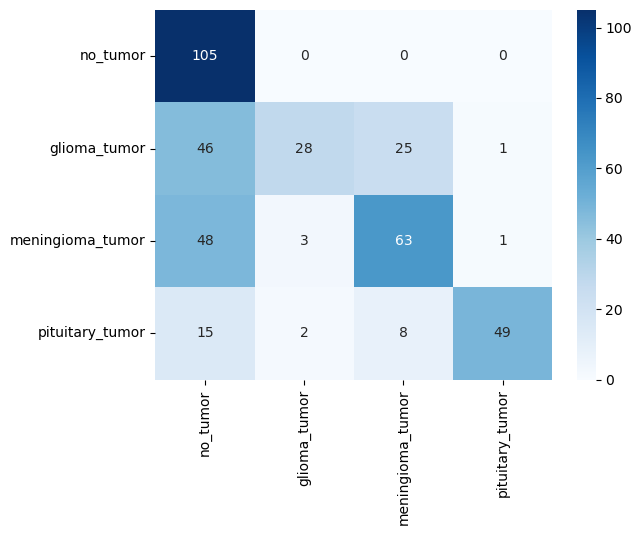

In [55]:
# convert one-hot labels back to class labels
y_true_labels = np.argmax(y_test_encoded, axis=1)
y_pred_labels = np.argmax(y_pred_encoded, axis=1)

cm = confusion_matrix(np.argmax(y_test_encoded, axis=1), np.argmax(y_pred_encoded, axis=1))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=list(set(y_test)), yticklabels=list(set(y_test)))

#### Overall, we can see that our regularized model actually performs worse than our non-regularized model. There can be various reasons for this. One possibility is that our regularization is too aggressive for this problem, given our small dataset. With overly aggressive regularization, our model is unable to learn crucial information. If given more data, it's possible results would be different.

#### Experimenting with the hyperparameters of our model, and the hyperparameters of our regularization techniques could perhaps help overcome this problem. Additionally, we could perform data augmentation, creating new images for our training set using transformations. One other approach is choosing a different model architecture that is more suitable for this task.